# Data preparation and feature selection

We present different techniques for encode the data and prepare them for applying ML algorithms. Also we present techniques for feature selection.

By Mario Martín, modify by Manuel Gijón on April 2024.

----

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn.neighbors as nb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import (
    mutual_info_classif,
    SelectKBest
)
from sklearn.model_selection import (
    StratifiedKFold,
    cross_val_score,
    cross_val_predict,
    GridSearchCV
)
from sklearn.feature_selection import (
    mutual_info_classif,
    SelectKBest,
)

from sklearn.metrics import make_scorer, precision_score, recall_score

%matplotlib inline

In [10]:
URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
# The dataset does not contains header, but this names for the features has been found in dataset's description
names = [
    "Age", "Workclass", "fnlwgt", "Education",
    "Education-Num", "Martial Status", "Occupation", "Relationship",
    "Race", "Sex", "Capital Gain", "Capital Loss",
    "Hours per week", "Country", "Target"
]

df = pd.read_csv(
    URL,
    sep=',',
    na_values=" ?",
    header=None,
    names=names
)

df=df.drop(labels='fnlwgt',axis=1)
df.head(n=10)

,Age,Workclass,Education,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


# DATA TRANSFORMATION: Encoding

## OneHotEncoding

In [11]:
# Categorical to numerical using OneHotEncoding for all features
pd.get_dummies(df).head()

,Age,Education-Num,Capital Gain,Capital Loss,Hours per week,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,Workclass_ Private,Workclass_ Self-emp-inc,...,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia,Target_ <=50K,Target_ >50K
0,39,13,2174,0,40,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
1,50,13,0,0,13,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,38,9,0,0,40,0,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0
3,53,7,0,0,40,0,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0
4,28,13,0,0,40,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [12]:
#df.groupby('Workclass').head()
df.groupby('Workclass').size()

Workclass
 Federal-gov           960
 Local-gov            2093
 Never-worked            7
 Private             22696
 Self-emp-inc         1116
 Self-emp-not-inc     2541
 State-gov            1298
 Without-pay            14
dtype: int64

In [13]:
df.describe()

,Age,Education-Num,Capital Gain,Capital Loss,Hours per week
count,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,10.080679,1077.648844,87.303830,40.437456
std,13.640433,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,48.000000,12.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


In [14]:
#Categorical to numerical using OneHotEncoding for some features (Workclass) and removing one value
pd.get_dummies(df, columns=["Workclass"],drop_first=True).head()

,Age,Education,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target,Workclass_ Local-gov,Workclass_ Never-worked,Workclass_ Private,Workclass_ Self-emp-inc,Workclass_ Self-emp-not-inc,Workclass_ State-gov,Workclass_ Without-pay
0,39,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,0,0,0,0,0,1,0
1,50,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,0,0,0,0,1,0,0
2,38,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,0,0,1,0,0,0,0
3,53,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,0,0,1,0,0,0,0
4,28,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,0,0,1,0,0,0,0


## LabelEncoding

Attend the proportions in which each categorical value is presented in the feature.

In [15]:
df.groupby('Education').size() / len(df)

Education
 10th            0.028654
 11th            0.036086
 12th            0.013298
 1st-4th         0.005160
 5th-6th         0.010227
 7th-8th         0.019840
 9th             0.015786
 Assoc-acdm      0.032769
 Assoc-voc       0.042443
 Bachelors       0.164461
 Doctorate       0.012684
 HS-grad         0.322502
 Masters         0.052916
 Preschool       0.001566
 Prof-school     0.017690
 Some-college    0.223918
dtype: float64

In [16]:
df.shape

(32561, 14)

In [17]:
# We are going to create a dictionary with the category and the value we want to replace it for
Education_dict = {
 ' Preschool': 1,
 ' 1st-4th': 2,
 ' 5th-6th': 3,
 ' 7th-8th': 4,
 ' 9th': 5,
 ' 10th': 6,
 ' 11th': 7,
 ' 12th': 8,
 ' Some-college': 9,
 ' Prof-school': 10,
 ' Bachelors': 11,
 ' Assoc-acdm': 12,
 ' Assoc-voc': 13,
 ' HS-grad': 14,
 ' Masters': 15,
 ' Doctorate': 16}

df['Education'] = df.Education.map(Education_dict)  # OBS: Python allows us to use a dictionary as a 'function'
                                                    # in this case, no need to create a lambda

In [18]:
df.groupby('Education').size()/ len(df)

Education
1     0.001566
2     0.005160
3     0.010227
4     0.019840
5     0.015786
6     0.028654
7     0.036086
8     0.013298
9     0.223918
10    0.017690
11    0.164461
12    0.032769
13    0.042443
14    0.322502
15    0.052916
16    0.012684
dtype: float64

# DATA TRANSFORMATION: Normalization

In [6]:
import pandas as pd

df = pd.read_csv("dades_preprocessades.csv")
X_bank = df.values[:,2:]
y_bank = df.values[:,1]

In [7]:
df.describe()

,Year_1,Current assets_1,Cost goods sold_1,DEP and AMO_1,EBITDA_1,Inventory_1,Net income_1,Total Receivables_1,Market value_1,Net sales_1,...,Net sales_3,Total assets_3,Long-term debt_3,EBIT_3,Gross Profit_3,Current Liabilities _3,Retained Earnings_3,Total Revenue_3,Total Liabilities_3,Operating Expenses_3
count,7310.000000,7310.000000,7310.000000,7310.000000,7310.000000,7310.000000,7310.000000,7310.000000,7310.000000,7310.000000,...,7310.000000,7310.000000,7310.000000,7310.000000,7310.000000,7310.000000,7310.000000,7310.000000,7310.000000,7310.000000
mean,2010.023393,798.073034,1288.220050,114.610857,313.624063,167.777297,99.606616,250.475278,3097.479900,1949.243461,...,2213.199690,2961.361750,890.510675,242.439578,754.204890,641.706017,457.333572,2213.199690,1944.662389,1844.248983
std,5.959468,4252.226473,7762.951934,687.099519,1782.242918,1009.000678,984.454874,1377.061553,17929.525846,10549.543306,...,12094.178066,15154.120537,4601.400627,1563.079443,4113.233588,3626.350048,6867.785982,12094.178066,10082.903688,10552.574745
min,1999.000000,-1.124000,0.000000,0.000000,-4118.000000,0.000000,-13082.000000,0.000000,0.000700,-244.189000,...,-1181.604000,0.001000,0.000000,-8851.000000,-6887.000000,0.002000,-69645.000000,-1181.604000,0.002000,0.018000
25%,2005.000000,16.075000,14.208750,0.968500,-2.170500,0.000000,-12.459500,2.433250,28.378750,21.203750,...,21.824250,30.014500,0.000000,-5.508250,5.879500,9.264250,-141.380000,21.824250,14.102500,28.733750
50%,2012.000000,82.191000,79.010000,6.141000,7.796000,4.130000,-0.240000,17.326500,167.350100,137.616000,...,152.442500,177.877000,6.113000,1.833000,53.429500,43.320000,-20.956000,152.442500,78.489000,146.946500
75%,2016.000000,349.945500,479.364750,42.207500,103.497750,49.859000,21.881500,103.020500,1047.193950,824.690500,...,915.860500,1110.777000,245.555750,68.466750,329.804500,223.269250,83.146500,915.860500,613.018750,780.146500
max,2016.000000,139660.000000,351176.000000,25847.000000,69276.000000,43199.000000,45687.000000,57591.000000,603253.566300,482154.000000,...,511729.000000,531864.000000,166250.000000,70662.000000,137106.000000,116866.000000,402089.000000,511729.000000,337980.000000,481580.000000


In [38]:
# OBS: we are going to train a model with this data, just to check its performance without standarize the data.
# - Apply Stratified K Fold to reduce the effect of the variability presented on the data on the final model.
# - Using cross validation technique we train different models on each one of the 'folds' and check the main
#   performance.

cv = StratifiedKFold(
    n_splits=10,
    random_state=1,
    shuffle=True
)

cv_scores = cross_val_score(
    nb.KNeighborsClassifier(),
    X=X_bank,
    y=y_bank,
    cv=cv,
    scoring='accuracy',
)
np.mean(cv_scores)

0.9201094391244871

In [39]:
# OBS: we are going to use Grid Search (GS) in order to find the best hyperparameters for this model
# For each one of the hyperparameters of the model we try the next possible values
# GS will train a model for each one of the possible combinations (BE AWARE OF THE COMPUTATIONAL COST)
params = {
    "n_neighbors":list(range(1,20,2)),
    "weights":('distance','uniform')
}

knc = nb.KNeighborsClassifier()
cv = StratifiedKFold(
    n_splits=10,
    random_state=1,
    shuffle=True
)
clf = GridSearchCV(
    knc,  # The instance of the model
    param_grid = params,  # The dictionary with pairs hyperparameter - possible values
    cv = cv,  # If cv is integer, by default is Stratifyed
    n_jobs=-1
)
clf.fit(X_bank, y_bank)
print("Best Params=",clf.best_params_, "Accuracy=", clf.best_score_)

Best Params= {'n_neighbors': 9, 'weights': 'distance'} Accuracy= 0.9225718194254446


In [40]:
# Poor score. What could happen?
# Remeber that all columns should be in the same range for KNN!!
# Could be that each colum is in a different range?

for i in range(13):
    print('std:',X_bank[:,i].std(),'min',X_bank[:,i].min(),'max',X_bank[:,i].max())

std: 5.959060051560879 min 1999 max 2016
std: 4251.93561313563 min -1.124 max 139660.0
std: 7762.420933995892 min 0.0 max 351176.0
std: 687.052519882528 min 0.0 max 25847.0
std: 1782.1210096243663 min -4118.0 max 69276.0
std: 1008.9316602333463 min 0.0 max 43199.0
std: 984.3875355526981 min -13082.0 max 45687.0
std: 1376.9673596177142 min 0.0 max 57591.0
std: 17928.299433893015 min 0.0007 max 603253.5663
std: 10548.821698702373 min -244.189 max 482154.0
std: 13408.414424719012 min 0.001 max 403821.0
std: 3834.8494895830327 min 0.0 max 113681.0
std: 1296.3003687007242 min -6133.0 max 59476.0


In [41]:
# One way is to standarize all data mean 0, std 1
scaler = StandardScaler().fit(X_bank)
X2=scaler.transform(X_bank)

for i in range(13):
    print('std:',X2[:,i].std(),'min',X2[:,i].min(),'max',X2[:,i].max())

std: 1.0 min -1.849854258470049 max 1.0029446482209936
std: 1.0 min -0.187960756477013 max 32.65852063626579
std: 1.0 min -0.16595596411034352 max 45.07456925167746
std: 1.0 min -0.1668152779131641 max 37.45330727752017
std: 0.9999999999999999 min -2.4867133259364853 max 38.69679756004421
std: 1.0 min -0.16629203291610575 max 42.65028485001056
std: 1.0 min -13.390667942777302 max 46.31041306187325
std: 1.0 min -0.18190356952841408 max 41.642617249896816
std: 1.0 min -0.17277038527274294 max 33.47534932760775
std: 0.9999999999999999 min -0.20793151348417668 max 45.52212277867816
std: 1.0 min -0.20062090324690052 max 29.916362821207372
std: 1.0 min -0.20784699096747467 max 29.43634121219501
std: 1.0000000000000002 min -4.884680556224554 max 45.727817583970804


In [19]:
# EX: try to repeat the process for training a new model but now with the new standarized dataset and check
# the performance.

# FEATURE SELECTION: Effect of irrelevant columns

/var/folders/9y/h_htr0yd59j121xzw7vclx6h0000gn/T/ipykernel_65694/2171491062.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5,4,i)


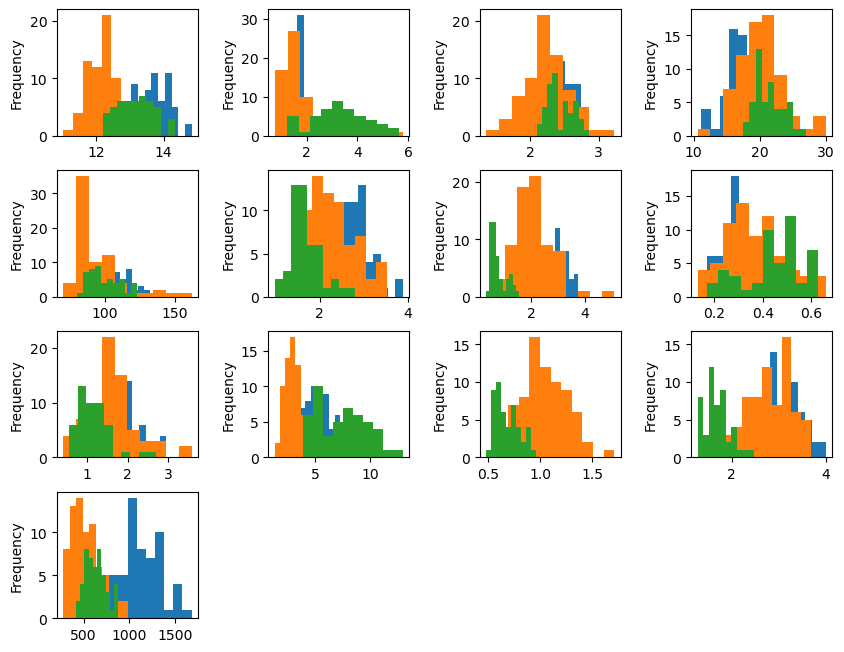

In [34]:
# Could you say wich features are more important (contain more information about the target variable's value)
# attending only to their distributions?

plt.subplots(figsize=(10, 10))
plt.subplots_adjust(hspace=0.27,wspace=0.5)
for i in range(1,14):
    plt.subplot(5,4,i)
    df[y_wine==1][i].plot.hist(bins=10)
    df[y_wine==2][i].plot.hist(bins=10)
    df[y_wine==3][i].plot.hist(bins=10)
plt.show()

In [42]:
nrcols=55
col = np.random.random(size=(X2.shape[0],nrcols))
scaler = StandardScaler().fit(col)
irelevant = scaler.transform(col)
for i in range(nrcols):
    print('std:',irelevant[:,i].std(),'min',irelevant[:,i].min(),'max',irelevant[:,i].max())

std: 0.9999999999999972 min -1.7304814518229623 max 1.7156689708992523
std: 0.9999999999999983 min -1.7399222082048267 max 1.7297735509724748
std: 1.0000000000000009 min -1.7439872312595792 max 1.7264032042160395
std: 1.0000000000000007 min -1.7238731391839723 max 1.7380086760143347
std: 0.9999999999999982 min -1.7093599536784203 max 1.7176620650794159
std: 1.0000000000000002 min -1.7242149544130112 max 1.7544142070510225
std: 1.0000000000000018 min -1.7580396918624797 max 1.7296254818678296
std: 1.0000000000000002 min -1.7234596996725096 max 1.7244642859840722
std: 0.999999999999999 min -1.747396695934191 max 1.756379338409707
std: 1.0 min -1.741774260496603 max 1.7359164739152368
std: 1.000000000000001 min -1.7285010309446982 max 1.7550234345207931
std: 0.9999999999999999 min -1.7355849299973487 max 1.7559330420579407
std: 0.9999999999999981 min -1.7283202423661022 max 1.7238511427139096
std: 0.9999999999999991 min -1.7265344656800736 max 1.730055517918403
std: 1.0 min -1.75107677432

In [43]:
X2_new = np.hstack((X2,irelevant))
cv = StratifiedKFold(
    n_splits = 10,
    random_state = 1,
    shuffle = True
)
cv_scores = cross_val_score(
    nb.KNeighborsClassifier(n_neighbors = 9),
    X = X2_new,
    y = y_bank,
    cv = cv,
    scoring = "accuracy"  # the metric we use for evaluate the performance
)
print(np.mean(cv_scores))

0.9205198358413134


In [44]:
knc = nb.KNeighborsClassifier()
cv = StratifiedKFold(
    n_splits = 10,
    random_state = 1,
    shuffle = True
)
clf = GridSearchCV(
    knc,
    param_grid = params,
    cv = cv,
    n_jobs = -1
)
clf.fit(X2_new, y_bank)
print(f"Best Params = {clf.best_params_} - Accuracy = {clf.best_score_}")

Best Params = {'n_neighbors': 11, 'weights': 'distance'} - Accuracy = 0.9210670314637485


# Feature Selection: Ranking

Lets pressent a technique for measuring the relevance of each one of the features in order to create the classifier.

In [45]:
# Select k best features following a given measure. Fit that on whole data set and return only relevant columns
X_reduced = SelectKBest(mutual_info_classif, k=2).fit_transform(X2_new, y_bank)

# Let's do now the 10-fold cross-validation again
cv = StratifiedKFold(
    n_splits=10,
    random_state=1,
    shuffle=True
)
clf = GridSearchCV(knc, param_grid=params,cv=cv,n_jobs=-1,)  # If cv is integer, by default is Stratifyed
clf.fit(X_reduced, y_bank)
print("Best Params=",clf.best_params_, "Accuracy=", clf.best_score_)

Best Params= {'n_neighbors': 17, 'weights': 'uniform'} Accuracy= 0.9214774281805745


In [46]:
# Select k best features following a given measure. Fit that on whole data set and return only relevant columns
X_reduced = SelectKBest(mutual_info_classif, k=13).fit_transform(X2_new, y_bank)

# Let's do now the 10-fold cross-validation again
cv = StratifiedKFold(
    n_splits=10,
    random_state=1,
    shuffle=True
)
clf = GridSearchCV(knc, param_grid=params,cv=cv,n_jobs=-1)  # If cv is integer, by default is Stratifyed
clf.fit(X_reduced, y_bank)
print("Best Params=",clf.best_params_, "Accuracy=", clf.best_score_)

Best Params= {'n_neighbors': 13, 'weights': 'distance'} Accuracy= 0.9242134062927496


In [47]:
X2_new.shape

(178, 33)

55
['Net income_3']
['Year_1', 'Net income_3']
['Year_1', 'Net income_2', 'Net income_3']
['Year_1', 'Net income_2', 'Net income_3', 'Market value_3']
['Year_1', 'Net income_2', 'Net income_3', 'Market value_3', 'Retained Earnings_3']
['Year_1', 'Net income_2', 'Net income_3', 'Market value_3', 'EBIT_3', 'Retained Earnings_3']
['Year_1', 'Net income_1', 'Net income_2', 'Net income_3', 'Market value_3', 'EBIT_3', 'Retained Earnings_3']
['Year_1', 'Net income_1', 'Market value_1', 'Net income_2', 'Net income_3', 'Market value_3', 'EBIT_3', 'Retained Earnings_3']
['Year_1', 'Net income_1', 'Market value_1', 'Net income_2', 'Retained Earnings_2', 'Net income_3', 'Market value_3', 'EBIT_3', 'Retained Earnings_3']
['Year_1', 'Net income_1', 'Market value_1', 'Net income_2', 'Retained Earnings_2', 'Net income_3', 'Market value_3', 'EBIT_3', 'Gross Profit_3', 'Retained Earnings_3']
['Year_1', 'Net income_1', 'Market value_1', 'Net income_2', 'Retained Earnings_2', 'EBITDA_3', 'Net income_3', '

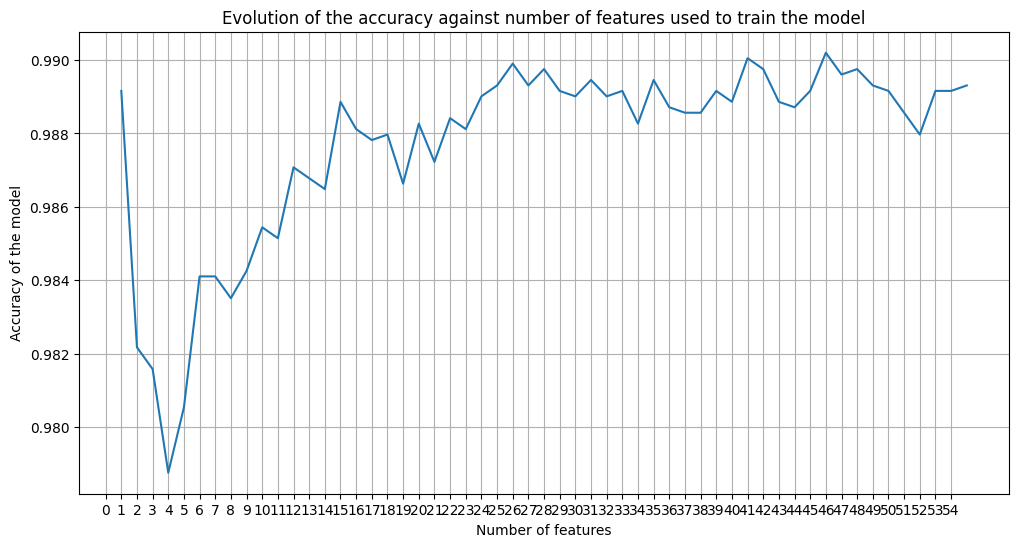

In [51]:
import numpy as np
from sklearn.metrics import make_scorer, precision_score, recall_score

original = np.zeros(55)


recall = make_scorer(recall_score, pos_label="failed")

X_bank_df = pd.DataFrame(X_bank, columns=df.columns[2:])

print(len(X_bank_df.columns))

for i in range(55):
    selector = SelectKBest(mutual_info_classif, k=i+1)
    X_reduced = selector.fit_transform(X2, y_bank)
    cols_idxs = selector.get_support(indices=True)
    nombres = [X_bank_df.columns[j] for j in cols_idxs]
    cv = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    cv_scores = cross_val_score(nb.KNeighborsClassifier(), X=X_reduced,y=y_bank, cv=cv, scoring=recall)
    original[i]=np.mean(cv_scores)

fig = plt.figure(figsize = (12, 6))  # Just declare the figure object and give dimensions
plt.grid(True)
plt.title("Evolution of the accuracy against number of features used to train the model")
plt.ylabel("Accuracy of the model")
plt.xlabel("Number of features")
plt.xticks(np.arange(0, 55, step=1))
plt.plot(range(1,56), original)
plt.show()